In [1]:
import os
import json
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import codecs
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import matplotsoccer as mps
from itertools import product
from kloppy import wyscout
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.spadl.config import actiontypes, results, bodyparts
import h5py
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns',None)

Data Prep

In [2]:
# -------------------------------
# JSON Dosyalarını Oku
# -------------------------------
project_dir = Path(os.getcwd())
players_path = project_dir / "data" / "wyscout_opensource" / "raw" / "players.json"
teams_path   = project_dir / "data" / "wyscout_opensource" / "raw" / "teams.json"

with open(players_path, 'r', encoding='utf-8') as f:
    players_data = json.load(f)
players_df = pd.DataFrame(players_data)

with open(teams_path, 'r', encoding='utf-8') as f:
    teams_data = json.load(f)
teams_df = pd.DataFrame(teams_data)

In [3]:
# matches_England.json dosyasının tam path'i
matches_json_path = project_dir / "data" / "wyscout_opensource" / "raw" / "matches_England.json"

# JSON'u oku  
with open(matches_json_path, "r", encoding="utf-8") as f:
    matches = json.load(f)

# Tüm wyId'leri al, unique yap, küçükten büyüğe sırala
match_ids = sorted(set(match["wyId"] for match in matches))
print(f"Toplam {len(match_ids)} unique maç bulundu.")

# --- MATCH META LOOKUP TABLE ---
match_meta = {
    m["wyId"]: {
        "gameweek": m.get("gameweek"),
        "dateutc": m.get("dateutc"),
        "winner": m.get("winner"),
        "venue": m.get("venue"),
        "referees": m.get("referees"),
        "label": m.get("label")
    }
    for m in matches
}

# Her maç için ayrı DF oluştur, listeye ekle
dfs = []
failed_matches = []

for mid in match_ids:
    try:
        ds = wyscout.load_open_data(match_id=mid)
        df = ds.to_pandas()  # EventDataset -> DataFrame
        df["matchId"] = mid   # match_id kolonu ekle

        # --- BURAYA META KOLONLARI EKLENİYOR ---
        meta = match_meta[mid]
        df["gameweek"] = meta["gameweek"]
        df["dateutc"] = meta["dateutc"]
        df["winner"] = meta["winner"]
        df["venue"] = meta["venue"]
        df["label"] = meta["label"]
        df["referees"] = [meta["referees"]] * len(df)

        dfs.append(df)

    except Exception as e:
        print(f"Match {mid} yüklenirken hata oluştu: {e}")
        failed_matches.append(mid)
        continue

# Tüm DF'leri concat et
if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    print("Tüm maçlar başarıyla birleştirildi.")
    print(f"Toplam event sayısı: {len(full_df)}")
else:
    print("Hiçbir maç yüklenemedi.")

if failed_matches:
    print("Başarısız maçlar:", failed_matches)


Toplam 380 unique maç bulundu.


C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\A

Match 2499738 yüklenirken hata oluştu: 'NoneType' object is not subscriptable


C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\A

Match 2500033 yüklenirken hata oluştu: 'NoneType' object is not subscriptable


C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\A

Match 2500039 yüklenirken hata oluştu: 'NoneType' object is not subscriptable


C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame


Match 2500042 yüklenirken hata oluştu: 'NoneType' object is not subscriptable
Match 2500043 yüklenirken hata oluştu: 'NoneType' object is not subscriptable


C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_9760\2039801127.py:32: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\A

Match 2500098 yüklenirken hata oluştu: 'NoneType' object is not subscriptable
Tüm maçlar başarıyla birleştirildi.
Toplam event sayısı: 651633
Başarısız maçlar: [2499738, 2500033, 2500039, 2500042, 2500043, 2500098]


In [4]:
# ID sütunlarını integer yap
full_df['player_id'] = full_df['player_id'].fillna(0).astype(int)
full_df['team_id'] = full_df['team_id'].fillna(0).astype(int)
players_df['wyId'] = players_df['wyId'].astype(int)
teams_df['wyId'] = teams_df['wyId'].astype(int)

# Unicode escape dizilerini çöz
def decode_unicode_escapes(name):
    if pd.isna(name):
        return name
    return codecs.decode(name, 'unicode_escape')

# Mapping
player_map = dict(zip(players_df['wyId'], players_df['shortName'].apply(decode_unicode_escapes)))
team_map = dict(zip(teams_df['wyId'], teams_df['name'].apply(decode_unicode_escapes)))

full_df['player_name'] = full_df['player_id'].map(player_map)
full_df['team_name'] = full_df['team_id'].map(team_map)


In [5]:
# 1️⃣ Home ve Away takımlarını label sütunundan çıkarıyoruz
def extract_teams(label):
    # Örn: 'Tottenham Hotspur - Leicester City, 5 - 4'
    teams_part = label.split(',')[0].strip()  # 'Tottenham Hotspur - Leicester City'
    home_team, away_team = [x.strip() for x in teams_part.split('-')]
    return pd.Series([home_team, away_team])

full_df[['home_team', 'away_team']] = full_df['label'].apply(extract_teams)

# 2️⃣ Maç sonucunu H, A, D olarak çıkarıyoruz
def extract_result(label):
    score_part = label.split(',')[1].strip()  # '5 - 4'
    home_score, away_score = [int(x.strip()) for x in score_part.split('-')]
    if home_score > away_score:
        return 'H'
    elif home_score < away_score:
        return 'A'
    else:
        return 'D'

full_df['match_result'] = full_df['label'].apply(extract_result)

# 3️⃣ is_home sütunu
full_df['is_home'] = (full_df['team_name'] == full_df['home_team']).astype(int)

full_df

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,result,success,body_part_type,duel_type,set_piece_type,goalkeeper_type,card_type,matchId,gameweek,dateutc,winner,venue,label,referees,player_name,team_name,home_team,away_team,match_result,is_home
0,177959171,PASS,1,0 days 00:00:02.758649,None,None,None,1609,25413,0.490142,0.491029,0.317004,0.769510,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Lacazette,Arsenal,Arsenal,Leicester City,H,1
1,177959172,PASS,1,0 days 00:00:04.946850,None,None,None,1609,370224,0.317004,0.769510,0.509858,0.742549,NaN,False,HIGH_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",R. Holding,Arsenal,Arsenal,Leicester City,H,1
2,177959173,PASS,1,0 days 00:00:06.542188,None,None,None,1609,3319,0.509858,0.742549,0.354742,0.706601,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",M. Özil,Arsenal,Arsenal,Leicester City,H,1
3,177959174,PASS,1,0 days 00:00:08.143395,None,None,None,1609,120339,0.354742,0.706601,0.411348,0.946440,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Mohamed Elneny,Arsenal,Arsenal,Leicester City,H,1
4,177959175,PASS,1,0 days 00:00:10.302366,None,None,None,1609,167145,0.411348,0.946440,0.711299,0.871455,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Bellerín,Arsenal,Arsenal,Leicester City,H,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651628,251621842,DUEL,2,0 days 00:50:55.590071,None,None,None,1631,419784,0.065476,0.935728,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",H. Choudhury,Leicester City,Tottenham Hotspur,Leicester City,H,0
651629,251621795,DUEL,2,0 days 00:50:56.333973,None,None,None,1624,13484,0.934524,0.064272,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",D. Alli,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1
651630,251621843,BALL_OUT,2,0 days 00:51:01.998929,None,None,None,1631,0,0.078571,1.000000,NaN,NaN,NaN,False,NaN,None,None,NaN,NaN,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",NaN,Leicester City,Tottenham Hotspur,Leicester City,H,0
651631,251621797,PASS,2,0 days 00:51:11.680085,None,None,None,1624,8292,0.908333,0.000000,0.645258,0.053560,NaN,False,HAND_PASS,COMPLETE,True,NaN,NaN,THROW_IN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",D. Rose,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1


clubelo

In [6]:
clubelo_path   = project_dir / "data" / "clubelo" / "clubelo.csv"

clubelo_df = pd.read_csv(clubelo_path)

clubelo_df['Club'].unique()

array(['Arsenal', 'Bournemouth', 'Brighton', 'Burnley', 'Chelsea',
       'Crystal Palace', 'Everton', 'Huddersfield', 'Leicester',
       'Liverpool', 'Man City', 'Man United', 'Newcastle', 'Southampton',
       'Stoke', 'Swansea', 'Tottenham', 'Watford', 'West Brom',
       'West Ham'], dtype=object)

In [7]:
full_df['team_name'].unique()

array(['Arsenal', 'Leicester City', 'Manchester City',
       'Brighton & Hove Albion', 'Burnley', 'Chelsea', 'Crystal Palace',
       'Huddersfield Town', 'Stoke City', 'Everton', 'Manchester United',
       'West Ham United', 'Tottenham Hotspur', 'Newcastle United',
       'Swansea City', 'Southampton', 'Watford', 'Liverpool',
       'West Bromwich Albion', 'AFC Bournemouth'], dtype=object)

In [8]:
# Eski ve yeni isimleri eşle
name_mapping = {
    'Bournemouth': 'AFC Bournemouth',
    'Brighton': 'Brighton & Hove Albion',
    'Huddersfield': 'Huddersfield Town',
    'Liverpool': 'Liverpool',
    'Leicester': 'Leicester City',
    'Man City': 'Manchester City',
    'Man United': 'Manchester United',
    'Newcastle': 'Newcastle United',
    'Stoke': 'Stoke City',
    'Swansea': 'Swansea City',
    'Tottenham': 'Tottenham Hotspur',
    'West Brom': 'West Bromwich Albion',
    'West Ham': 'West Ham United'
}

# Club kolonundaki isimleri değiştir
clubelo_df['Club'] = clubelo_df['Club'].replace(name_mapping)

In [9]:
# Önce tarihleri datetime formatına çevir
full_df['dateutc'] = pd.to_datetime(full_df['dateutc'])
clubelo_df['From'] = pd.to_datetime(clubelo_df['From'])
clubelo_df['To'] = pd.to_datetime(clubelo_df['To'])

# 1) Benzersiz kombinasyonları al
matches_df = full_df[['matchId', 'dateutc', 'home_team', 'away_team']].drop_duplicates()

# 2) Elo ekleme fonksiyonu
def get_elo_fast(team, date, clubelo_df):
    # dateutc'den büyük veya eşit From'ları al
    mask = (clubelo_df['Club'] == team) & (clubelo_df['From'] >= date)
    if mask.any():
        min_from_idx = clubelo_df.loc[mask, 'From'].idxmin()
        return clubelo_df.loc[min_from_idx, 'Elo']
    else:
        return np.nan

# 3) Home ve Away Elo'ları ekle
matches_df['home_elo'] = matches_df.apply(lambda row: get_elo_fast(row['home_team'], row['dateutc'], clubelo_df), axis=1)
matches_df['away_elo'] = matches_df.apply(lambda row: get_elo_fast(row['away_team'], row['dateutc'], clubelo_df), axis=1)

# 4) Full_df ile merge ederek Elo'ları ekle
full_df = full_df.merge(matches_df[['matchId', 'home_elo', 'away_elo']], on='matchId', how='left')

full_df

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,result,success,body_part_type,duel_type,set_piece_type,goalkeeper_type,card_type,matchId,gameweek,dateutc,winner,venue,label,referees,player_name,team_name,home_team,away_team,match_result,is_home,home_elo,away_elo
0,177959171,PASS,1,0 days 00:00:02.758649,None,None,None,1609,25413,0.490142,0.491029,0.317004,0.769510,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Lacazette,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612
1,177959172,PASS,1,0 days 00:00:04.946850,None,None,None,1609,370224,0.317004,0.769510,0.509858,0.742549,NaN,False,HIGH_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",R. Holding,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612
2,177959173,PASS,1,0 days 00:00:06.542188,None,None,None,1609,3319,0.509858,0.742549,0.354742,0.706601,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",M. Özil,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612
3,177959174,PASS,1,0 days 00:00:08.143395,None,None,None,1609,120339,0.354742,0.706601,0.411348,0.946440,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Mohamed Elneny,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612
4,177959175,PASS,1,0 days 00:00:10.302366,None,None,None,1609,167145,0.411348,0.946440,0.711299,0.871455,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Bellerín,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651628,251621842,DUEL,2,0 days 00:50:55.590071,None,None,None,1631,419784,0.065476,0.935728,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",H. Choudhury,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950
651629,251621795,DUEL,2,0 days 00:50:56.333973,None,None,None,1624,13484,0.934524,0.064272,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",D. Alli,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1,1916.024658,1698.673950
651630,251621843,BALL_OUT,2,0 days 00:51:01.998929,None,None,None,1631,0,0.078571,1.000000,NaN,NaN,NaN,False,NaN,None,None,NaN,NaN,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",NaN,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950
651631,251621797,PASS,2,0 days 00:51:11.680085,None,None,None,1624,8292,0.908333,0.000000,0.645258,0.053560,NaN,False,HAND_PASS,COMPLETE,True,NaN,NaN,THROW_IN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",D. Rose,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1,1916.024658,1698.673950


In [10]:
print(set(full_df['away_team']) - set(clubelo_df['Club']))


set()


xG

In [11]:
xg_path   = project_dir / "data" / "events_with_xg.csv"

xg_df = pd.read_csv(xg_path)

xg_df['game_id'] = xg_df['game_id'].astype(int)
xg_df['period_id'] = xg_df['period_id'].astype(int)

xg_df

,game_id,action_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,db_path,xG
0,2499719,0,1,2.758649,1609.0,25413.0,51.45,34.68,32.55,14.96,0,0,1,../cse-552-project/data/wyscout_opensource/spa...,0.0
1,2499719,1,1,4.946850,1609.0,370224.0,32.55,14.96,53.55,17.00,0,0,1,../cse-552-project/data/wyscout_opensource/spa...,0.0
2,2499719,2,1,6.542188,1609.0,3319.0,53.55,17.00,36.75,19.72,1,0,1,../cse-552-project/data/wyscout_opensource/spa...,0.0
3,2499719,3,1,8.143395,1609.0,120339.0,36.75,19.72,43.05,3.40,1,0,1,../cse-552-project/data/wyscout_opensource/spa...,0.0
4,2499719,4,1,10.302366,1609.0,167145.0,43.05,3.40,75.60,8.16,0,0,1,../cse-552-project/data/wyscout_opensource/spa...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321475,2517044,1150,2,2817.761761,2463.0,94831.0,17.85,31.28,17.85,31.28,0,11,0,../cse-552-project/data/wyscout_opensource/spa...,0.0
2321476,2517044,1151,2,2818.280436,2451.0,14917.0,17.85,31.96,23.10,27.20,0,10,1,../cse-552-project/data/wyscout_opensource/spa...,0.0
2321477,2517044,1152,2,2823.180681,2451.0,14804.0,23.10,27.20,0.00,3.40,0,21,1,../cse-552-project/data/wyscout_opensource/spa...,0.0
2321478,2517044,1153,2,2828.080925,2451.0,14804.0,0.00,3.40,5.25,4.76,0,0,0,../cse-552-project/data/wyscout_opensource/spa...,0.0


In [12]:
xg_positive_df = xg_df[xg_df['xG'] > 0.0]

# matchId bazında grupla, period_id ve timestamp'e göre sırala
xg_positive_df = xg_positive_df.sort_values(by=['game_id', 'period_id', 'time_seconds']).reset_index(drop=True)

# Her matchId için action_id 0'dan başlasın
xg_positive_df['shot_action_id'] = xg_positive_df.groupby('game_id').cumcount()

xg_positive_df['shot_action_id'] = xg_positive_df['shot_action_id'].astype(str)

xg_positive_df


,game_id,action_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,db_path,xG,shot_action_id
0,2499719,34,1,94.595788,1609.0,25413.0,92.40,40.12,105.0,37.4,0,11,1,../cse-552-project/data/wyscout_opensource/spa...,0.155541,0
1,2499719,40,1,179.854785,1631.0,26150.0,15.75,35.36,0.0,27.2,0,11,0,../cse-552-project/data/wyscout_opensource/spa...,0.140430,1
2,2499719,60,1,254.745027,1631.0,14763.0,4.20,35.36,0.0,34.0,1,11,1,../cse-552-project/data/wyscout_opensource/spa...,0.279815,2
3,2499719,87,1,425.824035,1609.0,7868.0,85.05,45.56,105.0,40.8,0,11,0,../cse-552-project/data/wyscout_opensource/spa...,0.035304,3
4,2499719,175,1,815.462015,1609.0,7868.0,78.75,47.60,105.0,37.4,0,11,0,../cse-552-project/data/wyscout_opensource/spa...,0.011927,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8876,2500098,983,2,1972.969422,1633.0,8561.0,75.60,37.40,105.0,40.8,0,11,0,../cse-552-project/data/wyscout_opensource/spa...,0.014340,24
8877,2500098,1043,2,2193.887080,1633.0,41174.0,90.30,45.56,105.0,30.6,0,11,1,../cse-552-project/data/wyscout_opensource/spa...,0.067651,25
8878,2500098,1068,2,2377.197700,1623.0,7879.0,12.60,42.16,0.0,34.0,0,11,0,../cse-552-project/data/wyscout_opensource/spa...,0.126562,26
8879,2500098,1070,2,2381.481625,1623.0,145692.0,8.40,25.84,0.0,37.4,0,11,0,../cse-552-project/data/wyscout_opensource/spa...,0.188408,27


In [13]:
# full_df'i matchId, period_id ve timestamp'e göre sırala
full_df = full_df.sort_values(by=['matchId', 'period_id', 'timestamp']).reset_index(drop=True)

# action_id’yi 0'dan başlayarak ver
full_df['action_id'] = full_df.groupby('matchId').cumcount()

# Yeni bir sütun oluştur, başta hepsi NaN olsun
full_df['shot_action_id'] = np.nan

# Sadece event_type == 'SHOT' olanlar için cumcount uygula
full_df.loc[full_df['event_type'].str.upper() == 'SHOT', 'shot_action_id'] = \
    full_df[full_df['event_type'].str.upper() == 'SHOT'].groupby('matchId').cumcount()

# NaN olanlar da dahil, string yap
full_df['shot_action_id'] = full_df['shot_action_id'].astype('str')

# .0 kısmını kaldırmak için sağdan 2 karakteri sil
full_df['shot_action_id'] = full_df['shot_action_id'].str[:-2]

shots_df = full_df[full_df['event_type'] == 'SHOT']

shots_df


,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,result,success,body_part_type,duel_type,set_piece_type,goalkeeper_type,card_type,matchId,gameweek,dateutc,winner,venue,label,referees,player_name,team_name,home_team,away_team,match_result,is_home,home_elo,away_elo,action_id,shot_action_id
47,177959212,SHOT,1,0 days 00:01:34.595788,None,None,None,1609,25413,0.877778,0.411513,1.0,0.455147,NaN,False,NaN,GOAL,True,RIGHT_FOOT,NaN,NaN,REFLEX,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Lacazette,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,47,0
63,177959247,SHOT,1,0 days 00:02:59.854785,None,None,None,1631,26150,0.851587,0.517941,1.0,0.399958,NaN,False,NaN,OFF_TARGET,False,LEFT_FOOT,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",R. Mahrez,Leicester City,Arsenal,Leicester City,H,0,1851.603760,1713.677612,63,1
93,177959280,SHOT,1,0 days 00:04:14.745027,None,None,None,1631,14763,0.965079,0.517941,1.0,0.500000,NaN,False,NaN,GOAL,True,HEAD_OTHER,NaN,NaN,REFLEX,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",S. Okazaki,Leicester City,Arsenal,Leicester City,H,0,1851.603760,1713.677612,93,2
131,177959289,SHOT,1,0 days 00:07:05.824035,None,None,None,1609,7868,0.796208,0.329346,1.0,0.399958,NaN,False,NaN,OFF_TARGET,False,LEFT_FOOT,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Oxlade-Chamberlain,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,131,3
256,177959429,SHOT,1,0 days 00:13:35.462015,None,None,None,1609,7868,0.739602,0.302386,1.0,0.455147,NaN,False,NaN,SAVED,False,RIGHT_FOOT,NaN,NaN,SAVE_ATTEMPT,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Oxlade-Chamberlain,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,256,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651315,251621477,SHOT,2,0 days 00:30:37.598666,None,None,None,1624,8717,0.860317,0.356307,1.0,0.544853,NaN,False,NaN,GOAL,True,RIGHT_FOOT,NaN,NaN,REFLEX,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",H. Kane,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1,1916.024658,1698.673950,1240,26
651323,251621530,SHOT,2,0 days 00:32:02.569019,None,None,None,1631,285508,0.947619,0.588487,1.0,0.500000,NaN,False,NaN,SAVED,False,LEFT_FOOT,NaN,NaN,REFLEX,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",K. Iheanacho,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950,1248,27
651326,251621533,SHOT,2,0 days 00:32:06.921716,None,None,None,1631,14853,0.711299,0.182105,1.0,0.600042,NaN,False,NaN,OFF_TARGET,False,LEFT_FOOT,NaN,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",C. Fuchs,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950,1251,28
651436,251621609,SHOT,2,0 days 00:39:02.553411,None,None,None,1624,8717,0.822879,0.275425,1.0,0.399958,NaN,False,NaN,OFF_TARGET,False,RIGHT_FOOT,NaN,FREE_KICK,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'r

In [14]:
# xg_df’den sadece gerekli kolonları al
xg_subset = xg_positive_df[['game_id', 'period_id', 'shot_action_id', 'xG']].copy()


# merge işlemi
full_df = pd.merge(
    full_df,
    xg_subset,
    left_on=['matchId', 'period_id', 'shot_action_id'],
    right_on=['game_id', 'period_id', 'shot_action_id'],
    how='left'  # full_df'deki tüm satırları koru
)

# artık game_id kolonu gereksizse silebilirsin
full_df = full_df.drop(columns=['game_id'])

full_df


,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,result,success,body_part_type,duel_type,set_piece_type,goalkeeper_type,card_type,matchId,gameweek,dateutc,winner,venue,label,referees,player_name,team_name,home_team,away_team,match_result,is_home,home_elo,away_elo,action_id,shot_action_id,xG
0,177959171,PASS,1,0 days 00:00:02.758649,None,None,None,1609,25413,0.490142,0.491029,0.317004,0.769510,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Lacazette,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,0,n,NaN
1,177959172,PASS,1,0 days 00:00:04.946850,None,None,None,1609,370224,0.317004,0.769510,0.509858,0.742549,NaN,False,HIGH_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",R. Holding,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,1,n,NaN
2,177959173,PASS,1,0 days 00:00:06.542188,None,None,None,1609,3319,0.509858,0.742549,0.354742,0.706601,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",M. Özil,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,2,n,NaN
3,177959174,PASS,1,0 days 00:00:08.143395,None,None,None,1609,120339,0.354742,0.706601,0.411348,0.946440,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Mohamed Elneny,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,3,n,NaN
4,177959175,PASS,1,0 days 00:00:10.302366,None,None,None,1609,167145,0.411348,0.946440,0.711299,0.871455,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Bellerín,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,4,n,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651628,251621842,DUEL,2,0 days 00:50:55.590071,None,None,None,1631,419784,0.065476,0.935728,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",H. Choudhury,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950,1553,n,NaN
651629,251621795,DUEL,2,0 days 00:50:56.333973,None,None,None,1624,13484,0.934524,0.064272,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",D. Alli,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1,1916.024658,1698.673950,1554,n,NaN
651630,251621843,BALL_OUT,2,0 days 00:51:01.998929,None,None,None,1631,0,0.078571,1.000000,NaN,NaN,NaN,False,NaN,None,None,NaN,NaN,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",NaN,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950,1555,n,NaN
651631,251621797,PASS,2,0 days 00:51:11.680085,None,None,None,1624,8292,0.908333,0.000000,0.645258,0.053560,NaN,False,HAND_PASS,COMPLETE,True,NaN,NaN,THROW_IN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",D. Ros

In [15]:
full_df['xG'] = full_df['xG'].fillna(0)

xg_positive_df = full_df[full_df['xG'] > 0.0]

xg_positive_df


,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,result,success,body_part_type,duel_type,set_piece_type,goalkeeper_type,card_type,matchId,gameweek,dateutc,winner,venue,label,referees,player_name,team_name,home_team,away_team,match_result,is_home,home_elo,away_elo,action_id,shot_action_id,xG
47,177959212,SHOT,1,0 days 00:01:34.595788,None,None,None,1609,25413,0.877778,0.411513,1.0,0.455147,NaN,False,NaN,GOAL,True,RIGHT_FOOT,NaN,NaN,REFLEX,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Lacazette,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,47,0,0.155541
63,177959247,SHOT,1,0 days 00:02:59.854785,None,None,None,1631,26150,0.851587,0.517941,1.0,0.399958,NaN,False,NaN,OFF_TARGET,False,LEFT_FOOT,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",R. Mahrez,Leicester City,Arsenal,Leicester City,H,0,1851.603760,1713.677612,63,1,0.140430
93,177959280,SHOT,1,0 days 00:04:14.745027,None,None,None,1631,14763,0.965079,0.517941,1.0,0.500000,NaN,False,NaN,GOAL,True,HEAD_OTHER,NaN,NaN,REFLEX,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",S. Okazaki,Leicester City,Arsenal,Leicester City,H,0,1851.603760,1713.677612,93,2,0.279815
131,177959289,SHOT,1,0 days 00:07:05.824035,None,None,None,1609,7868,0.796208,0.329346,1.0,0.399958,NaN,False,NaN,OFF_TARGET,False,LEFT_FOOT,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Oxlade-Chamberlain,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,131,3,0.035304
256,177959429,SHOT,1,0 days 00:13:35.462015,None,None,None,1609,7868,0.739602,0.302386,1.0,0.455147,NaN,False,NaN,SAVED,False,RIGHT_FOOT,NaN,NaN,SAVE_ATTEMPT,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Oxlade-Chamberlain,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,256,4,0.011927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651315,251621477,SHOT,2,0 days 00:30:37.598666,None,None,None,1624,8717,0.860317,0.356307,1.0,0.544853,NaN,False,NaN,GOAL,True,RIGHT_FOOT,NaN,NaN,REFLEX,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",H. Kane,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1,1916.024658,1698.673950,1240,26,0.085662
651323,251621530,SHOT,2,0 days 00:32:02.569019,None,None,None,1631,285508,0.947619,0.588487,1.0,0.500000,NaN,False,NaN,SAVED,False,LEFT_FOOT,NaN,NaN,REFLEX,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",K. Iheanacho,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950,1248,27,0.278868
651326,251621533,SHOT,2,0 days 00:32:06.921716,None,None,None,1631,14853,0.711299,0.182105,1.0,0.600042,NaN,False,NaN,OFF_TARGET,False,LEFT_FOOT,NaN,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",C. Fuchs,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950,1251,28,0.003010
651436,251621609,SHOT,2,0 days 00:39:02.553411,None,None,None,1624,8717,0.822879,0.275425,1.0,0.399958,NaN,False,NaN,OFF_TARGET,False,RIGHT_FOOT,NaN,FREE_KICK,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley

xT

291022
    event_id event_type  period_id              timestamp end_timestamp  \
0  177959171       PASS          1 0 days 00:00:02.758649          None   
1  177959172       PASS          1 0 days 00:00:04.946850          None   
2  177959173       PASS          1 0 days 00:00:06.542188          None   
3  177959174       PASS          1 0 days 00:00:08.143395          None   
4  177959175       PASS          1 0 days 00:00:10.302366          None   

  ball_state ball_owning_team  team_id  player_id    start_x    start_y  \
0       None             None     1609      25413  51.464932  33.390000   
1       None             None     1609     370224  33.285440  52.326667   
2       None             None     1609       3319  53.535068  50.493333   
3       None             None     1609     120339  37.247865  48.048889   
4       None             None     1609     167145  43.191503  64.357895   

       end_x      end_y  receiver_player_id is_counter_attack    pass_type  \
0  33.285440 

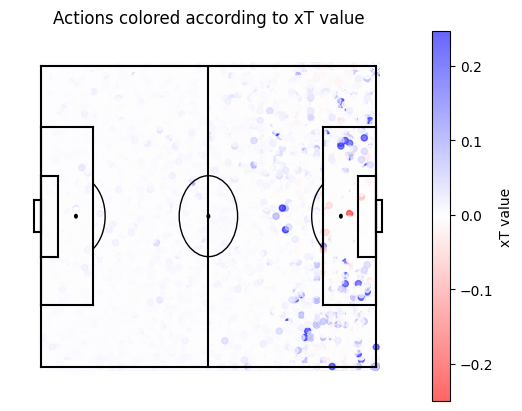

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,result,success,body_part_type,duel_type,set_piece_type,goalkeeper_type,card_type,matchId,gameweek,dateutc,winner,venue,label,referees,player_name,team_name,home_team,away_team,match_result,is_home,home_elo,away_elo,action_id,shot_action_id,xG,coordinates_x_scaled,coordinates_y_scaled,end_coordinates_x_scaled,end_coordinates_y_scaled,xT_value
0,177959171,PASS,1,0 days 00:00:02.758649,None,None,None,1609,25413,0.490142,0.491029,0.317004,0.769510,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Lacazette,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,0,n,0.0,51.464932,33.390000,33.285440,52.326667,-0.004251
1,177959172,PASS,1,0 days 00:00:04.946850,None,None,None,1609,370224,0.317004,0.769510,0.509858,0.742549,NaN,False,HIGH_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",R. Holding,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,1,n,0.0,33.285440,52.326667,53.535068,50.493333,0.006261
2,177959173,PASS,1,0 days 00:00:06.542188,None,None,None,1609,3319,0.509858,0.742549,0.354742,0.706601,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",M. Özil,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,2,n,0.0,53.535068,50.493333,37.247865,48.048889,-0.004164
3,177959174,PASS,1,0 days 00:00:08.143395,None,None,None,1609,120339,0.354742,0.706601,0.411348,0.946440,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Mohamed Elneny,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,3,n,0.0,37.247865,48.048889,43.191503,64.357895,-0.001429
4,177959175,PASS,1,0 days 00:00:10.302366,None,None,None,1609,167145,0.411348,0.946440,0.711299,0.871455,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Bellerín,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,4,n,0.0,43.191503,64.357895,74.686379,59.258947,0.012753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651628,251621842,DUEL,2,0 days 00:50:55.590071,None,None,None,1631,419784,0.065476,0.935728,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",H. Choudhury,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950,1553,n,0.0,6.875000,63.629474,NaN,NaN,0.000000
651629,251621795,DUEL,2,0 days 00:50:56.333973,None,None,None,1624,13484,0.934524,0.064272,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",D. Alli,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1,1916.024658,1698.673950,1554,n,0.0,98.125000,4.370526,NaN,NaN,0.000000
651630,251621843,BALL_OUT,2,0 days 00:51:01.998929,None,None,None,1631,0,0.078571,1.000000,NaN,NaN,NaN,False,NaN,None,None,NaN,NaN,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951,

In [16]:
# Scale coordinates
full_df["coordinates_x_scaled"] = full_df["coordinates_x"] * 105
full_df["coordinates_y_scaled"] = full_df["coordinates_y"] * 68
full_df["end_coordinates_x_scaled"]   = full_df["end_coordinates_x"]   * 105
full_df["end_coordinates_y_scaled"]   = full_df["end_coordinates_y"]   * 68

# Convert timestamp to nice time
def nice_time(row):
    total_seconds = row.timestamp.total_seconds()
    minute = int((row.period_id-1)*45 + total_seconds // 60)
    second = int(total_seconds % 60)
    return f"{minute}m{second}s"

# -------------------------
# 1️⃣ type_id ve result_id mapping
# -------------------------
unique_events = full_df["event_type"].str.lower().unique()
actiontype2id = {name: i for i, name in enumerate(unique_events)}
result2id = {"complete": 1, "fail": 0}

# -------------------------
# 2️⃣ SPADL dönüşümü (sadece xT için)
# -------------------------
spadl_df = full_df.copy()

# Koordinatları SPADL isimleri ile ekle
spadl_df.rename(columns={
    "coordinates_x": "start_x",
    "coordinates_y": "start_y",
    "end_coordinates_x": "end_x",
    "end_coordinates_y": "end_y"
}, inplace=True)

# type_id ve result_id
spadl_df["type_id"] = spadl_df["event_type"].str.lower().map(actiontype2id)
spadl_df = spadl_df[spadl_df["success"].notna()].copy()
spadl_df["result_id"] = spadl_df["success"].astype(int)

# Scale coordinates
spadl_df["start_x"] = spadl_df["start_x"] * 105
spadl_df["start_y"] = spadl_df["start_y"] * 68
spadl_df["end_x"]   = spadl_df["end_x"]   * 105
spadl_df["end_y"]   = spadl_df["end_y"]   * 68

# Gerekli sütunlar için dropna
spadl_cols = ["type_id", "result_id", "team_id", "start_x", "start_y", "end_x", "end_y", "event_id"]
spadl_df = spadl_df.dropna(subset=spadl_cols).copy()

# -------------------------
# 3️⃣ xT model
# -------------------------
url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xTModel = xthreat.load_model(url_grid)

mov_actions = xthreat.get_successful_move_actions(spadl_df)
if len(mov_actions) == 0:
    print("⚠️ Topu ilerleten aksiyon bulunamadı.")
else:
    mov_actions["xT_value"] = xTModel.rate(mov_actions)

    full_df = full_df.merge(
        mov_actions[["event_id", "xT_value"]],
        on="event_id",  # sadece sütun adı
        how="left"
    )

    full_df['xT_value'] = full_df['xT_value'].fillna(0)

    print(len(mov_actions))
    print(mov_actions.head())
    print(mov_actions.dtypes)
    print(full_df.dtypes)


    # -------------------------
    # 5️⃣ Görselleştirme
    # -------------------------
    mps.field(show=False)
    plt.title("Actions colored according to xT value")
    plt.scatter(
        full_df.coordinates_x_scaled, 
        full_df.coordinates_y_scaled, 
        c=full_df.xT_value, 
        cmap="bwr_r",
        s=20,
        alpha=0.6
    )
    plt.colorbar(label="xT value")
    plt.show()

full_df

VAEP

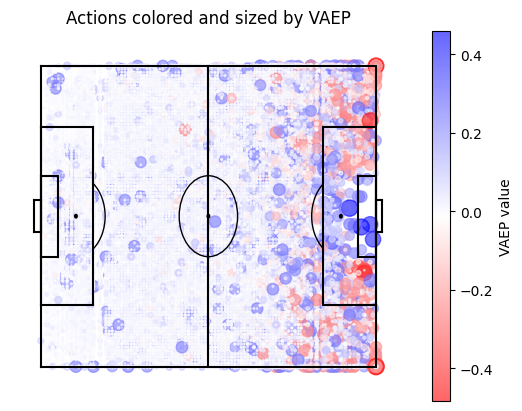

,player_name,team_name,VAEP
8,A. Doucouré,Watford,6.012008
428,R. Sterling,Manchester City,5.428666
375,N. Kanté,Chelsea,5.091495
376,N. Matić,Manchester United,4.807629
142,David Silva,Manchester City,4.255011
172,Fernandinho,Manchester City,3.996219
134,D. Tadić,Southampton,3.693378
221,J. Henderson,Liverpool,3.668644
71,Bernardo Silva,Manchester City,3.623891
433,Richarlison,Watford,3.433456


In [17]:
# -------------------------
# VAEP hesaplama
# -------------------------
# df_spadl'i full_df üzerinden oluştur
df_spadl = full_df.copy()

# type_id ve result_id ekle
df_spadl["type_id"] = df_spadl["event_type"].str.lower().map(actiontype2id)

# True/False/None sorunu için güvenli dönüşüm
df_spadl = df_spadl[df_spadl["success"].notna()].copy()  # None olanları çıkar
df_spadl["result_id"] = df_spadl["success"].astype(int)  # True->1, False->0

# Koordinatları SPADL formatına çevir
df_spadl.rename(columns={
    "coordinates_x_scaled": "start_x",
    "coordinates_y_scaled": "start_y",
    "end_coordinates_x_scaled": "end_x",
    "end_coordinates_y_scaled": "end_y"
}, inplace=True)

# -------------------------
# 0️⃣ Koordinatlarda NaN varsa temizle (xTModel hatasını önlemek için)
# -------------------------
coord_cols = ["start_x", "start_y", "end_x", "end_y"]
df_spadl = df_spadl.dropna(subset=coord_cols).copy()

# -------------------------
# 1️⃣ Aksiyonları sırala
# -------------------------
actions = df_spadl.sort_values(["matchId","period_id","timestamp"]).copy()

# -------------------------
# 2️⃣ xG / VAEP hesaplama
# -------------------------
# Basit bir örnek olarak xT kullanıyoruz
actions["xT_value_before"] = xTModel.rate(actions)  # tüm aksiyonlar için xT

# Aynı oyun ve periyot içinde bir sonraki aksiyona bak
actions["xT_value_after"] = actions.groupby(["matchId","period_id"])["xT_value_before"].shift(-1)
actions["VAEP"] = actions["xT_value_after"] - actions["xT_value_before"]
actions["VAEP"] = actions["VAEP"].fillna(0)  # Son aksiyonlar için

# -------------------------
# 3️⃣ full_df ile merge et
# -------------------------
full_df = full_df.merge(
    actions[["event_id", "VAEP"]],
    on="event_id",
    how="left"
)
full_df["VAEP"] = full_df["VAEP"].fillna(0)

# -------------------------
# 4️⃣ Görselleştirme
# -------------------------
mps.field(show=False)
plt.title("Actions colored and sized by VAEP")
plt.scatter(
    full_df.coordinates_x_scaled,
    full_df.coordinates_y_scaled,
    c=full_df.VAEP,
    cmap="bwr_r",
    s=np.abs(full_df.VAEP)*300,
    alpha=0.6
)
plt.colorbar(label="VAEP value")
plt.show()

# -------------------------
# 5️⃣ Oyuncu bazlı toplam VAEP tablosu
# -------------------------
# Oyuncu ve takım isimlerini ekle
actions["player_name"] = full_df["player_name"]
actions["team_name"] = full_df["team_name"]

player_vaep = actions.groupby(["player_name", "team_name"])["VAEP"].sum().reset_index()
player_vaep = player_vaep.sort_values("VAEP", ascending=False)

# İlk 10 oyuncuyu göster
player_vaep.head(10)


In [18]:
full_df

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,result,success,body_part_type,duel_type,set_piece_type,goalkeeper_type,card_type,matchId,gameweek,dateutc,winner,venue,label,referees,player_name,team_name,home_team,away_team,match_result,is_home,home_elo,away_elo,action_id,shot_action_id,xG,coordinates_x_scaled,coordinates_y_scaled,end_coordinates_x_scaled,end_coordinates_y_scaled,xT_value,VAEP
0,177959171,PASS,1,0 days 00:00:02.758649,None,None,None,1609,25413,0.490142,0.491029,0.317004,0.769510,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",A. Lacazette,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,0,n,0.0,51.464932,33.390000,33.285440,52.326667,-0.004251,0.010512
1,177959172,PASS,1,0 days 00:00:04.946850,None,None,None,1609,370224,0.317004,0.769510,0.509858,0.742549,NaN,False,HIGH_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",R. Holding,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,1,n,0.0,33.285440,52.326667,53.535068,50.493333,0.006261,-0.010425
2,177959173,PASS,1,0 days 00:00:06.542188,None,None,None,1609,3319,0.509858,0.742549,0.354742,0.706601,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",M. Özil,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,2,n,0.0,53.535068,50.493333,37.247865,48.048889,-0.004164,0.002735
3,177959174,PASS,1,0 days 00:00:08.143395,None,None,None,1609,120339,0.354742,0.706601,0.411348,0.946440,NaN,False,HEAD_PASS,COMPLETE,True,HEAD,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Mohamed Elneny,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,3,n,0.0,37.247865,48.048889,43.191503,64.357895,-0.001429,0.014182
4,177959175,PASS,1,0 days 00:00:10.302366,None,None,None,1609,167145,0.411348,0.946440,0.711299,0.871455,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2499719,1,2017-08-11 18:45:00,1609,Emirates Stadium,"Arsenal - Leicester City, 4 - 3","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Bellerín,Arsenal,Arsenal,Leicester City,H,1,1851.603760,1713.677612,4,n,0.0,43.191503,64.357895,74.686379,59.258947,0.012753,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651628,251621842,DUEL,2,0 days 00:50:55.590071,None,None,None,1631,419784,0.065476,0.935728,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",H. Choudhury,Leicester City,Tottenham Hotspur,Leicester City,H,0,1916.024658,1698.673950,1553,n,0.0,6.875000,63.629474,NaN,NaN,0.000000,0.000000
651629,251621795,DUEL,2,0 days 00:50:56.333973,None,None,None,1624,13484,0.934524,0.064272,NaN,NaN,NaN,False,NaN,NEUTRAL,False,NaN,GROUND,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley Stadium,"Tottenham Hotspur - Leicester City, 5 - 4","[{'refereeId': 378951, 'role': 'referee'}, {'r...",D. Alli,Tottenham Hotspur,Tottenham Hotspur,Leicester City,H,1,1916.024658,1698.673950,1554,n,0.0,98.125000,4.370526,NaN,NaN,0.000000,0.000000
651630,251621843,BALL_OUT,2,0 days 00:51:01.998929,None,None,None,1631,0,0.078571,1.000000,NaN,NaN,NaN,False,NaN,None,None,NaN,NaN,NaN,NaN,NaN,2500097,38,2018-05-13 14:00:00,1624,Wembley St

In [19]:
#full_df.to_csv("../cse-552-project/data/full_df.csv", encoding="utf-8")

Benchmark

In [20]:
# DataFrame'e çevir
df_matches = pd.DataFrame(matches)

# dateutc'ye göre sırala
df_matches['dateutc'] = pd.to_datetime(df_matches['dateutc'])
df_matches = df_matches.sort_values('dateutc').reset_index(drop=True)

# Maç sonuçlarını temsil eden label değerleri
def result_from_label(label):
    if ',' not in label:
        return 'X'
    score_str = label.split(',')[-1].strip()  # "1 - 2" kısmı
    home, away = map(int, score_str.split(' - '))
    if home > away:
        return 'H'
    elif home < away:
        return 'A'
    else:
        return 'D'

df_matches['result'] = df_matches['label'].apply(result_from_label)

possible_results = ['H', 'D', 'A']

# 1) Full random tahmin
full_random_preds = np.random.choice(possible_results, size=len(df_matches))
df_matches['full_random'] = full_random_preds

# 2) İlk maç random, sonraki maçlar önceki maç sonucundan farklı tahmin
prev_diff_preds = []
for i in range(len(df_matches)):
    if i == 0:
        pred = np.random.choice(possible_results)
    else:
        prev_result = prev_diff_preds[-1]
        pred = np.random.choice([r for r in possible_results if r != prev_result])
    prev_diff_preds.append(pred)

df_matches['prev_diff'] = prev_diff_preds

# Doğru tahmin yüzdeleri
accuracy_full_random = (df_matches['result'] == df_matches['full_random']).mean()
accuracy_prev_diff = (df_matches['result'] == df_matches['prev_diff']).mean()

print(f"Full random doğru tahmin yüzdesi: {accuracy_full_random*100:.2f}%")

# 3x3 sonuç matrisi
conf_matrix_full_random = pd.crosstab(df_matches['result'], df_matches['full_random'], rownames=['Actual'], colnames=['Predicted'], dropna=False)
conf_matrix_prev_diff = pd.crosstab(df_matches['result'], df_matches['prev_diff'], rownames=['Actual'], colnames=['Predicted'], dropna=False)

# Matrisleri eksik değerleri doldurarak sırala
conf_matrix_full_random = conf_matrix_full_random.reindex(index=possible_results, columns=possible_results, fill_value=0)
conf_matrix_prev_diff = conf_matrix_prev_diff.reindex(index=possible_results, columns=possible_results, fill_value=0)

print("\nFull Random 3x3 Matrisi:")
print(conf_matrix_full_random)

Full random doğru tahmin yüzdesi: 38.95%

Full Random 3x3 Matrisi:
Predicted   H   D   A
Actual               
H          61  57  55
D          32  37  30
A          20  38  50


Random Forest Model wo xG, xT, VAEP and clubelo

Overall Match Prediction Accuracy: 0.37333333333333335
Draw distribution (train):
draw
0    0.732441
1    0.267559
Name: proportion, dtype: float64

Winner distribution (train, no draws):
winner
1.0    0.630137
0.0    0.369863
Name: proportion, dtype: float64

3-Class Combined Distribution (train):
home_win    0.461538
away_win    0.270903
draw        0.267559
Name: proportion, dtype: float64


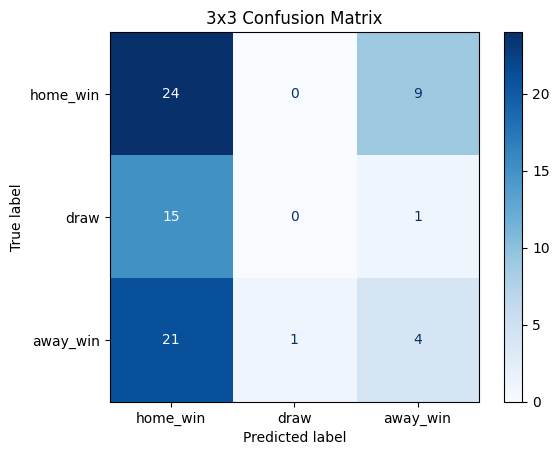

Stage 1 Feature Importances (Draw Model):
                    feature  importance
8     result_COMPLETE_count    0.075330
20        pass_success_rate    0.074318
3         coordinates_x_std    0.067946
2        coordinates_x_mean    0.064859
10  result_INCOMPLETE_count    0.063383
5         coordinates_y_std    0.061510
11        result_LOST_count    0.061467
4        coordinates_y_mean    0.060891
0                   matchId    0.057571
12     result_NEUTRAL_count    0.057495
7      result_BLOCKED_count    0.055629
18     result_SUCCESS_count    0.052687
19         result_WON_count    0.048760
14  result_OFF_TARGET_count    0.047671
15         result_OUT_count    0.038475
13     result_OFFSIDE_count    0.031635
17       result_SAVED_count    0.027302
9         result_GOAL_count    0.020232
1        pass_type__lambda_    0.015007
6        player_id__lambda_    0.009562

Stage 2 Feature Importances (Winner Model):
                    feature  importance
2        coordinates_x_mean    0.

In [21]:
# -------------------------------
# 1️⃣ İlk 30 Dakika Filtresi
# -------------------------------
df = full_df.copy()
df['seconds'] = df['timestamp'].dt.total_seconds()
first_30_min = df[(df['period_id'] == 1) & (df['seconds'] <= 1800)]

# -------------------------------
# 2️⃣ Fonksiyon: Mesafe Hesaplama
# -------------------------------
def compute_distance(row):
    if pd.notna(row['end_coordinates_x']) and pd.notna(row['end_coordinates_y']):
        dx = row['end_coordinates_x'] - row['coordinates_x']
        dy = row['end_coordinates_y'] - row['coordinates_y']
        return np.sqrt(dx**2 + dy**2)
    else:
        return 0

# -------------------------------
# 3️⃣ Fonksiyon: Maç + Takım Bazlı Detaylı Özet
# -------------------------------
def summarize_match_team(df):
    df = df.copy()
    df['distance'] = df.apply(compute_distance, axis=1)
    features = []

    grouped = df.groupby(['matchId', 'team_name'])
    for (matchId, team_name), group in grouped:
        feat = {'matchId': matchId, 'team_name': team_name}

        for evt in ['PASS','DUEL','BALL_OUT']:
            feat[f'event_{evt}_count'] = (group['event_type'] == evt).sum()
        feat['distinct_players'] = group['player_id'].nunique()
        feat['distance_avg'] = group['distance'].mean()
        feat['distance_std'] = group['distance'].std()

        for ptype in group['pass_type'].dropna().unique():
            feat[f'pass_type_{ptype}_count'] = (group['pass_type'] == ptype).sum()
        feat['success_rate'] = group['success'].mean() if 'success' in group else np.nan

        for col in ['body_part_type','duel_type','set_piece_type','goalkeeper_type','card_type']:
            for val in group[col].dropna().unique():
                feat[f'{col}_{val}_count'] = (group[col] == val).sum()
        features.append(feat)

    match_team_features = pd.DataFrame(features)
    return match_team_features

# -------------------------------
# 4️⃣ Fonksiyon: Maç Bazlı Özet
# -------------------------------
def summarize_match(df):
    result_counts = df.pivot_table(index='matchId', columns='result', aggfunc='size', fill_value=0)
    result_counts.columns = [f'result_{col}_count' for col in result_counts.columns]

    agg_dict = {
        'pass_type': lambda x: x.nunique(),
        'coordinates_x': ['mean', 'std'],
        'coordinates_y': ['mean', 'std'],
        'player_id': lambda x: x.nunique()
    }
    summary = df.groupby('matchId').agg(agg_dict)
    summary.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in summary.columns.values]
    summary = summary.merge(result_counts, left_index=True, right_index=True)

    if 'COMPLETE' in df['result'].unique():
        complete_counts = df[df['result']=='COMPLETE'].groupby('matchId').size()
        total_counts = df.groupby('matchId').size()
        summary['pass_success_rate'] = complete_counts / total_counts
    else:
        summary['pass_success_rate'] = np.nan

    if 'match_date' in df.columns:
        dates = df.groupby('matchId')['match_date'].first()
        summary = summary.merge(dates, left_index=True, right_index=True)

    return summary

def clean_column_names(df):
    df = df.copy()
    df.columns = [str(col).replace('[','_').replace(']','').replace('<','_').replace('>','_').replace(' ','_') for col in df.columns]
    return df

# -------------------------------
# 5️⃣ Maç Özeti ve match_result ile Etiketler
# -------------------------------
match_features = summarize_match(first_30_min)
match_features = clean_column_names(match_features)

# match_result: H (home win), A (away win), D (draw)
match_results = full_df.groupby('matchId')['match_result'].first().reset_index()
match_features = match_features.merge(match_results, on='matchId')

# Draw ve Winner sütunları
match_features['draw'] = (match_features['match_result'] == 'D').astype(int)
match_features['winner'] = match_features['match_result'].apply(
    lambda x: 1 if x=='H' else (0 if x=='A' else np.nan)
)

# -------------------------------
# 6️⃣ Train/Test Split
# -------------------------------
match_features = match_features.sort_values(by='match_date') if 'match_date' in match_features.columns else match_features
n = len(match_features)
train_size = int(0.8 * n)

train_data = match_features.iloc[:train_size]
test_data = match_features.iloc[train_size:]

X_train = train_data.drop(columns=['match_result','draw','winner','match_date'], errors='ignore')
y_train_draw = train_data['draw']
y_train_winner = train_data['winner']

X_test = test_data.drop(columns=['match_result','draw','winner','match_date'], errors='ignore')
y_test_draw = test_data['draw']
y_test_winner = test_data['winner']

# -------------------------------
# 🔹 Stage 1: Draw tahmini
# -------------------------------
model_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_stage1.fit(X_train, y_train_draw)

# -------------------------------
# 🔹 Stage 2: Home/Away winner tahmini (draw olmayanlar)
# -------------------------------
X_train_no_draw = X_train[y_train_draw==0]
y_train_winner_no_draw = y_train_winner[y_train_draw==0]
model_stage2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_stage2.fit(X_train_no_draw, y_train_winner_no_draw)

# -------------------------------
# 🔹 Test Seti Tahminleri
# -------------------------------
overall_pred = []
for idx, row in test_data.iterrows():
    X = row.drop(labels=['match_result','draw','winner','match_date'], errors='ignore').to_frame().T
    draw_pred = model_stage1.predict(X)[0]
    if draw_pred == 1:
        overall_pred.append('draw')
    else:
        winner_pred = model_stage2.predict(X)[0]
        overall_pred.append('home_win' if winner_pred == 1 else 'away_win')

# Gerçek sonuçlar
def real_result(row):
    if row['draw'] == 1:
        return 'draw'
    else:
        return 'home_win' if row['winner'] == 1 else 'away_win'

real_results = test_data.apply(real_result, axis=1)

# Overall accuracy
overall_acc = accuracy_score(real_results, overall_pred)
print("Overall Match Prediction Accuracy:", overall_acc)

# DRAW distribution
print("Draw distribution (train):")
print(y_train_draw.value_counts(normalize=True))

# WINNER distribution (only non-draw games)
print("\nWinner distribution (train, no draws):")
print(y_train_winner_no_draw.value_counts(normalize=True))

# Combined 3-class distribution for full train
train_results_combined = train_data.apply(real_result, axis=1)
print("\n3-Class Combined Distribution (train):")
print(train_results_combined.value_counts(normalize=True))

# -------------------------------
# 🔹 3x3 Confusion Matrix
# -------------------------------
labels = ['home_win', 'draw', 'away_win']
cm = confusion_matrix(real_results, overall_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("3x3 Confusion Matrix")
plt.show()

# -------------------------------
# 🔹 Detaylı Maç+Takım Özeti
# -------------------------------
match_team_features = summarize_match_team(first_30_min)
match_team_features.head()

feat_imp_stage1 = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_stage1.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Stage 1 Feature Importances (Draw Model):")
print(feat_imp_stage1.head(20))

feat_imp_stage2 = pd.DataFrame({
    'feature': X_train_no_draw.columns,
    'importance': model_stage2.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nStage 2 Feature Importances (Winner Model):")
print(feat_imp_stage2.head(20))


Logistic Regression wo xG, xT, VAEP and clubelo

c:\Users\Megad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Megad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://sciki

Overall Match Prediction Accuracy: 0.37333333333333335
Draw distribution (train):
draw
0    0.732441
1    0.267559
Name: proportion, dtype: float64

Winner distribution (train, no draws):
winner
1.0    0.630137
0.0    0.369863
Name: proportion, dtype: float64

3-Class Combined Distribution (train):
home_win    0.461538
away_win    0.270903
draw        0.267559
Name: proportion, dtype: float64


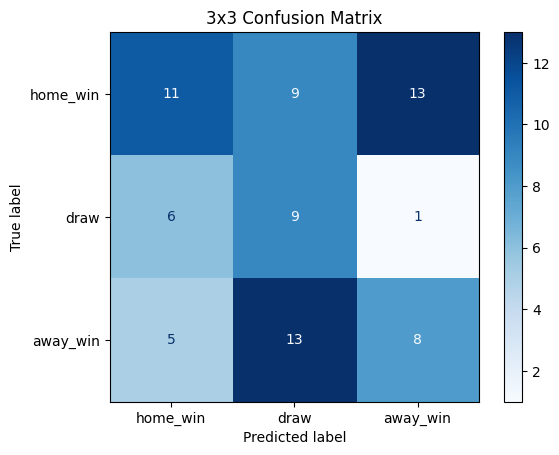


Stage 1 Logistic Regression Coefficients (Draw Model):
                    feature      coef
7      result_BLOCKED_count  0.279523
9         result_GOAL_count -0.212773
13     result_OFFSIDE_count  0.162176
14  result_OFF_TARGET_count  0.110864
1        pass_type__lambda_ -0.108882
11        result_LOST_count -0.062804
18     result_SUCCESS_count -0.062754
17       result_SAVED_count  0.059737
19         result_WON_count  0.041528
16        result_POST_count  0.029234
15         result_OUT_count -0.027307
6        player_id__lambda_  0.016671
8     result_COMPLETE_count -0.007944
10  result_INCOMPLETE_count  0.006291
12     result_NEUTRAL_count  0.005188
4        coordinates_y_mean  0.001417
20        pass_success_rate -0.000873
3         coordinates_x_std  0.000635
2        coordinates_x_mean  0.000233
5         coordinates_y_std  0.000208

Stage 2 Logistic Regression Coefficients (Winner Model):
                    feature      coef
9         result_GOAL_count -0.116170
14  result_O

In [22]:
# -------------------------------
# Stage 1: Draw tahmini (LogReg)
# -------------------------------
model_stage1 = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    solver='lbfgs'
)
model_stage1.fit(X_train, y_train_draw)

# -------------------------------
# Stage 2: Winner tahmini (home=1, away=0)
# -------------------------------
X_train_no_draw = X_train[y_train_draw==0]
y_train_winner_no_draw = y_train_winner[y_train_draw==0]

model_stage2 = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    solver='lbfgs'
)
model_stage2.fit(X_train_no_draw, y_train_winner_no_draw)

# -------------------------------
# Test Tahmini
# -------------------------------
overall_pred = []
for idx, row in test_data.iterrows():
    X = row.drop(labels=['match_result','draw','winner','match_date'], errors='ignore').to_frame().T
    
    draw_pred = model_stage1.predict(X)[0]
    if draw_pred == 1:
        overall_pred.append('draw')
    else:
        winner_pred = model_stage2.predict(X)[0]
        overall_pred.append('home_win' if winner_pred == 1 else 'away_win')

real_results = test_data.apply(real_result, axis=1)

# Accuracy
overall_acc = accuracy_score(real_results, overall_pred)
print("Overall Match Prediction Accuracy:", overall_acc)

# -------------------------------
# Sınıf Dağılımları
# -------------------------------
print("Draw distribution (train):")
print(y_train_draw.value_counts(normalize=True))

print("\nWinner distribution (train, no draws):")
print(y_train_winner_no_draw.value_counts(normalize=True))

train_results_combined = train_data.apply(real_result, axis=1)
print("\n3-Class Combined Distribution (train):")
print(train_results_combined.value_counts(normalize=True))

# -------------------------------
# Confusion Matrix
# -------------------------------
labels = ['home_win', 'draw', 'away_win']
cm = confusion_matrix(real_results, overall_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("3x3 Confusion Matrix")
plt.show()

# -------------------------------
# Feature Importances yerine Coefficients
# -------------------------------
coef_stage1 = pd.DataFrame({
    'feature': X_train.columns,
    'coef': model_stage1.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

print("\nStage 1 Logistic Regression Coefficients (Draw Model):")
print(coef_stage1.head(20))

coef_stage2 = pd.DataFrame({
    'feature': X_train_no_draw.columns,
    'coef': model_stage2.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

print("\nStage 2 Logistic Regression Coefficients (Winner Model):")
print(coef_stage2.head(20))


Random Forest Model w xG, xT, VAEP and clubelo

Overall Match Prediction Accuracy: 0.5066666666666667
Draw distribution (train):
draw
0    0.732441
1    0.267559
Name: proportion, dtype: float64

Winner distribution (train, no draws):
winner
1.0    0.630137
0.0    0.369863
Name: proportion, dtype: float64

3-Class Combined Distribution (train):
home_win    0.461538
away_win    0.270903
draw        0.267559
Name: proportion, dtype: float64


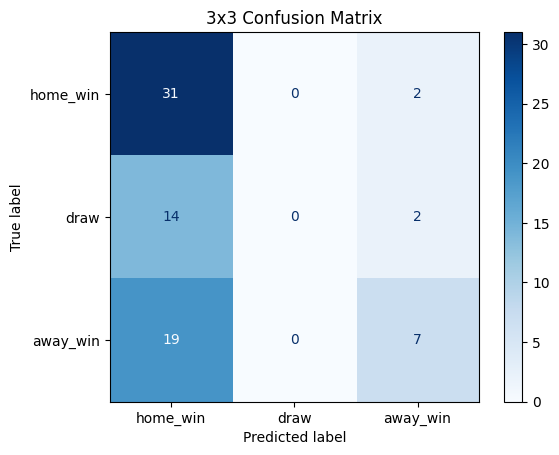

Stage 1 Feature Importances (Draw Model):
                        feature  importance
5                  distance_avg    0.040536
6                  distance_std    0.037907
46        result_COMPLETE_count    0.026668
36                     VAEP_std    0.026661
50         result_NEUTRAL_count    0.026257
29                      xG_mean    0.026214
16                 success_rate    0.025714
34              xT_value_cumsum    0.025219
48      result_INCOMPLETE_count    0.024972
7   pass_type_SIMPLE_PASS_count    0.023936
59                     home_elo    0.023789
30                       xG_std    0.023106
33                 xT_value_std    0.022154
32                xT_value_mean    0.022073
45         result_BLOCKED_count    0.021989
22       duel_type_GROUND_count    0.021359
1              event_PASS_count    0.021357
49            result_LOST_count    0.021260
60                     away_elo    0.020834
17    body_part_type_HEAD_count    0.020223

Stage 2 Feature Importances (Winn

In [23]:
# -------------------------------
# 1️⃣ İlk 30 Dakika Filtresi
# -------------------------------
df = full_df.copy()
df['seconds'] = df['timestamp'].dt.total_seconds()
first_30_min = df[(df['period_id'] == 1) & (df['seconds'] <= 1800)]

# -------------------------------
# 2️⃣ Fonksiyon: Mesafe Hesaplama
# -------------------------------
def compute_distance(row):
    if pd.notna(row['end_coordinates_x']) and pd.notna(row['end_coordinates_y']):
        dx = row['end_coordinates_x'] - row['coordinates_x']
        dy = row['end_coordinates_y'] - row['coordinates_y']
        return np.sqrt(dx**2 + dy**2)
    else:
        return 0

# -------------------------------
# 3️⃣ Fonksiyon: Maç + Takım Bazlı Detaylı Özet (xG, xT, VAEP, clubelo dahil)
# -------------------------------
def summarize_match_team(df):
    df = df.copy()
    df['distance'] = df.apply(compute_distance, axis=1)

    for metric in ['xG','xT_value','VAEP']:
        if metric in df.columns:
            df[f'{metric}_cumsum'] = df.groupby(['matchId','team_name'])[metric].cumsum()

    features = []
    grouped = df.groupby(['matchId','team_name'])
    
    for (matchId, team_name), group in grouped:
        feat = {'matchId': matchId, 'team_name': team_name}
        
        for evt in ['PASS','DUEL','BALL_OUT']:
            feat[f'event_{evt}_count'] = (group['event_type'] == evt).sum()
        
        feat['distinct_players'] = group['player_id'].nunique()
        feat['distance_avg'] = group['distance'].mean()
        feat['distance_std'] = group['distance'].std()
        
        for ptype in group['pass_type'].dropna().unique():
            feat[f'pass_type_{ptype}_count'] = (group['pass_type'] == ptype).sum()
        
        feat['success_rate'] = group['success'].mean() if 'success' in group else np.nan

        for col in ['body_part_type','duel_type','set_piece_type','goalkeeper_type','card_type']:
            for val in group[col].dropna().unique():
                feat[f'{col}_{val}_count'] = (group[col] == val).sum()
        
        for metric in ['xG','xT_value','VAEP']:
            if metric in group.columns:
                feat[f'{metric}_mean'] = group[metric].mean()
                feat[f'{metric}_std'] = group[metric].std()
                feat[f'{metric}_cumsum'] = group[f'{metric}_cumsum'].iloc[-1] if not group.empty else 0

        features.append(feat)
    
    return pd.DataFrame(features)

# -------------------------------
# 4️⃣ Fonksiyon: Maç Bazlı Özet (team features ile aggregate)
# -------------------------------
def summarize_match(df):
    team_feats = summarize_match_team(df)
    
    # Maç bazında aggregate
    agg_dict = {col:'sum' for col in team_feats.columns if col not in ['matchId','team_name']}
    match_summary = team_feats.groupby('matchId').agg(agg_dict)
    
    # Result counts
    result_counts = df.pivot_table(index='matchId', columns='result', aggfunc='size', fill_value=0)
    result_counts.columns = [f'result_{col}_count' for col in result_counts.columns]
    match_summary = match_summary.merge(result_counts, left_index=True, right_index=True)
    
    # Pass success rate
    if 'COMPLETE' in df['result'].unique():
        complete_counts = df[df['result']=='COMPLETE'].groupby('matchId').size()
        total_counts = df.groupby('matchId').size()
        match_summary['pass_success_rate'] = complete_counts / total_counts
    else:
        match_summary['pass_success_rate'] = np.nan

    # Match date
    if 'match_date' in df.columns:
        dates = df.groupby('matchId')['match_date'].first()
        match_summary = match_summary.merge(dates, left_index=True, right_index=True)

    # -------------------------------
    # Home/Away Elo ve is_home ekleme
    # -------------------------------
    match_elos = df.groupby('matchId').agg({
        'home_elo':'first',
        'away_elo':'first',
        'is_home':'first'
    })
    match_summary = match_summary.merge(match_elos, left_index=True, right_index=True)

    return match_summary

def clean_column_names(df):
    df = df.copy()
    df.columns = [str(col).replace('[','_').replace(']','').replace('<','_').replace('>','_').replace(' ','_') for col in df.columns]
    return df

# -------------------------------
# 5️⃣ Maç Özeti ve match_result ile Etiketler
# -------------------------------
match_features = summarize_match(first_30_min)
match_features = clean_column_names(match_features)

match_results = full_df.groupby('matchId')['match_result'].first().reset_index()
match_features = match_features.merge(match_results, on='matchId')

# Draw ve Winner sütunları
match_features['draw'] = (match_features['match_result'] == 'D').astype(int)
match_features['winner'] = match_features['match_result'].apply(lambda x: 1 if x=='H' else (0 if x=='A' else np.nan))

# -------------------------------
# 6️⃣ Train/Test Split
# -------------------------------
match_features = match_features.sort_values(by='match_date') if 'match_date' in match_features.columns else match_features
n = len(match_features)
train_size = int(0.8 * n)

train_data = match_features.iloc[:train_size]
test_data = match_features.iloc[train_size:]

X_train = train_data.drop(columns=['match_result','draw','winner','match_date'], errors='ignore')
y_train_draw = train_data['draw']
y_train_winner = train_data['winner']

X_test = test_data.drop(columns=['match_result','draw','winner','match_date'], errors='ignore')
y_test_draw = test_data['draw']
y_test_winner = test_data['winner']

# -------------------------------
# 🔹 Stage 1: Draw tahmini
# -------------------------------
model_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_stage1.fit(X_train, y_train_draw)

# -------------------------------
# 🔹 Stage 2: Home/Away winner tahmini (draw olmayanlar)
# -------------------------------
X_train_no_draw = X_train[y_train_draw==0]
y_train_winner_no_draw = y_train_winner[y_train_draw==0]
model_stage2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_stage2.fit(X_train_no_draw, y_train_winner_no_draw)

# -------------------------------
# 🔹 Test Seti Tahminleri
# -------------------------------
overall_pred = []
for idx, row in test_data.iterrows():
    X = row.drop(labels=['match_result','draw','winner','match_date'], errors='ignore').to_frame().T
    draw_pred = model_stage1.predict(X)[0]
    if draw_pred == 1:
        overall_pred.append('draw')
    else:
        winner_pred = model_stage2.predict(X)[0]
        overall_pred.append('home_win' if winner_pred == 1 else 'away_win')

# Gerçek sonuçlar
def real_result(row):
    if row['draw'] == 1:
        return 'draw'
    else:
        return 'home_win' if row['winner'] == 1 else 'away_win'

real_results = test_data.apply(real_result, axis=1)

# Overall accuracy
overall_acc = accuracy_score(real_results, overall_pred)
print("Overall Match Prediction Accuracy:", overall_acc)

# DRAW distribution
print("Draw distribution (train):")
print(y_train_draw.value_counts(normalize=True))

# WINNER distribution (only non-draw games)
print("\nWinner distribution (train, no draws):")
print(y_train_winner_no_draw.value_counts(normalize=True))

# Combined 3-class distribution for full train
train_results_combined = train_data.apply(real_result, axis=1)
print("\n3-Class Combined Distribution (train):")
print(train_results_combined.value_counts(normalize=True))

# -------------------------------
# 🔹 3x3 Confusion Matrix
# -------------------------------
labels = ['home_win', 'draw', 'away_win']
cm = confusion_matrix(real_results, overall_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("3x3 Confusion Matrix")
plt.show()

# -------------------------------
# 🔹 Detaylı Maç+Takım Özeti
# -------------------------------
match_team_features = summarize_match_team(first_30_min)
match_team_features.head()

feat_imp_stage1 = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_stage1.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Stage 1 Feature Importances (Draw Model):")
print(feat_imp_stage1.head(20))

feat_imp_stage2 = pd.DataFrame({
    'feature': X_train_no_draw.columns,
    'importance': model_stage2.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nStage 2 Feature Importances (Winner Model):")
print(feat_imp_stage2.head(20))

Logistic Regression w xG, xT, VAEP and clubelo

c:\Users\Megad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Megad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://sciki

Overall Match Prediction Accuracy: 0.4266666666666667
Draw distribution (train):
draw
0    0.732441
1    0.267559
Name: proportion, dtype: float64

Winner distribution (train, no draws):
winner
1.0    0.630137
0.0    0.369863
Name: proportion, dtype: float64

3-Class Combined Distribution (train):
home_win    0.461538
away_win    0.270903
draw        0.267559
Name: proportion, dtype: float64


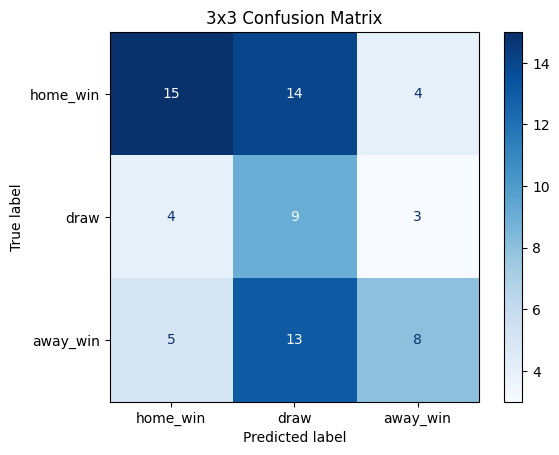


Stage 1 Logistic Regression Coefficients (Draw Model):
                               feature      coef
10              pass_type_LAUNCH_count  0.067592
56                result_SUCCESS_count -0.055330
45                result_BLOCKED_count  0.046112
3                 event_BALL_OUT_count  0.042645
41        card_type_FIRST_YELLOW_count -0.037978
24      set_piece_type_GOAL_KICK_count  0.036280
1                     event_PASS_count  0.035845
48             result_INCOMPLETE_count -0.032356
18     body_part_type_RIGHT_FOOT_count  0.031877
14               pass_type_CROSS_count -0.031037
28  goalkeeper_type_SAVE_ATTEMPT_count -0.030408
47                   result_GOAL_count -0.028408
7          pass_type_SIMPLE_PASS_count -0.026615
38     body_part_type_HEAD_OTHER_count  0.026508
49                   result_LOST_count -0.025150
39      duel_type_SLIDING_TACKLE_count -0.024427
51                result_OFFSIDE_count  0.023164
26       set_piece_type_THROW_IN_count -0.020814
15          p

In [24]:
# -------------------------------
# Stage 1: Draw tahmini (LogReg)
# -------------------------------
model_stage1 = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    solver='lbfgs'
)
model_stage1.fit(X_train, y_train_draw)

# -------------------------------
# Stage 2: Winner tahmini (home=1, away=0)
# -------------------------------
X_train_no_draw = X_train[y_train_draw==0]
y_train_winner_no_draw = y_train_winner[y_train_draw==0]

model_stage2 = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    solver='lbfgs'
)
model_stage2.fit(X_train_no_draw, y_train_winner_no_draw)

# -------------------------------
# Test Tahmini
# -------------------------------
overall_pred = []
for idx, row in test_data.iterrows():
    X = row.drop(labels=['match_result','draw','winner','match_date'], errors='ignore').to_frame().T
    
    draw_pred = model_stage1.predict(X)[0]
    if draw_pred == 1:
        overall_pred.append('draw')
    else:
        winner_pred = model_stage2.predict(X)[0]
        overall_pred.append('home_win' if winner_pred == 1 else 'away_win')

real_results = test_data.apply(real_result, axis=1)

# Accuracy
overall_acc = accuracy_score(real_results, overall_pred)
print("Overall Match Prediction Accuracy:", overall_acc)

# -------------------------------
# Sınıf Dağılımları
# -------------------------------
print("Draw distribution (train):")
print(y_train_draw.value_counts(normalize=True))

print("\nWinner distribution (train, no draws):")
print(y_train_winner_no_draw.value_counts(normalize=True))

train_results_combined = train_data.apply(real_result, axis=1)
print("\n3-Class Combined Distribution (train):")
print(train_results_combined.value_counts(normalize=True))

# -------------------------------
# Confusion Matrix
# -------------------------------
labels = ['home_win', 'draw', 'away_win']
cm = confusion_matrix(real_results, overall_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("3x3 Confusion Matrix")
plt.show()

# -------------------------------
# Feature Importances yerine Coefficients
# -------------------------------
coef_stage1 = pd.DataFrame({
    'feature': X_train.columns,
    'coef': model_stage1.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

print("\nStage 1 Logistic Regression Coefficients (Draw Model):")
print(coef_stage1.head(20))

coef_stage2 = pd.DataFrame({
    'feature': X_train_no_draw.columns,
    'coef': model_stage2.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

print("\nStage 2 Logistic Regression Coefficients (Winner Model):")
print(coef_stage2.head(20))
